In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
import time

from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from itertools import compress

#### Load Recipes Data

In [2]:
recipes = json.load(open('./data/recipe_train.json'))

#### Convert recipes to text documents

In [3]:
recipes_as_doc = {}

for sample in recipes:
    key = sample['cuisine']
    # If key is in the dictionary, return its value. If not, insert key with a value of default and return default.
    recipes_as_doc.setdefault(key,[]).append(' '.join(sample['ingredients']).lower())

# create a single list with all the documents
all_docs = []
for k, v in recipes_as_doc.items():
   all_docs.append(' '.join(v))

#### Tf-idf vectorizer for text data

In [4]:
# code adapted from https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf

vectorizer = TfidfVectorizer(use_idf=True)
transformed_documents = vectorizer.fit_transform(all_docs)

#### Analyze results

In [5]:
transformed_documents_as_array = transformed_documents.toarray()
docs_scores_dfs = {}

# loop each item in transformed_documents_as_array, using enumerate to keep track of the current position
for counter, doc in enumerate(transformed_documents_as_array):
    # construct a data frame
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame\
        .from_records(tf_idf_tuples, columns=['term', 'score'])\
        .sort_values(by='score', ascending=False)\
        .reset_index(drop=True)
    docs_scores_dfs[list(recipes_as_doc.keys())[counter]] = one_doc_as_df

    print(list(recipes_as_doc.keys())[counter], end=' ')
    # print(one_doc_as_df)
    # output to a csv using the enumerated value for the filename
    # one_doc_as_df.to_csv("tf.idf" + counter.__str__() + ".csv")

greek southern_us filipino indian jamaican spanish italian mexican chinese british thai vietnamese cajun_creole brazilian french japanese irish korean moroccan russian 

#### Statistics of Scores

In [6]:
statistics = {}
for k in docs_scores_dfs.keys():
    df = docs_scores_dfs[k]
    scores = df['score']
    scores = scores.loc[scores>0.0]
    statistics[k] = [scores.mean(), scores.max(), scores.min(), df['score'].astype(bool).sum(axis=0)]

#### Visualize a histogram of score for one cuisine 

Text(0, 0.5, 'Number of Therms')

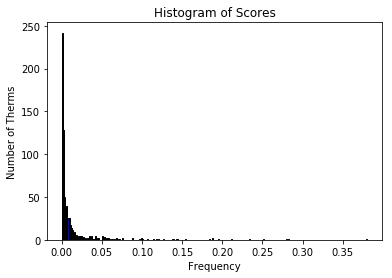

In [7]:
irish_scores = docs_scores_dfs["irish"]["score"]
irish_scores = irish_scores.loc[irish_scores>0.0]
plt.hist(irish_scores, color = 'blue', edgecolor = 'black', bins=300)
plt.title('Histogram of Scores')
plt.xlabel('Frequency')
plt.ylabel('Number of Therms')

#### Top 10 therms per cuisine

In [8]:
for k in docs_scores_dfs.keys():
    scores_df = docs_scores_dfs[k]
    # print('-------------')
    # print(k)
    # print(scores_df.iloc[:15,:])


#### Load Baskets Market Data

In [9]:
baskets = []
with open('./data/groceries.csv', newline=None) as f:
  reader = csv.reader(f)
  for row in reader:
    baskets.append([elem.replace(' ', '-') for elem in row])

#### Optimize computation
In order to optimize computation we compute ngram for tf.idf top score 


In [10]:
top_scores_ngram = {}
CUISINE_TOP_SCORE_THRESHOLD = 0.1
for cuisine in docs_scores_dfs.keys():
    scores_df = docs_scores_dfs[cuisine]
    scores_df = scores_df[scores_df['score']>CUISINE_TOP_SCORE_THRESHOLD]
    scores_df = scores_df.sort_values(by=['score'],ascending=False)
    
    ngram_scores = []
    for index, row in scores_df.iterrows():
        ngram = list(ngrams(row['term'], 3))
        score =  row['score']
        ngram_scores.append([ngram, score, row['term']])
        
    top_scores_ngram[cuisine] = ngram_scores

#### Define the distance metric 

In [11]:
def jaccard_distance(a, b):
    """Calculate the jaccard distance between sets A and B"""
    a = set(a)
    b = set(b)
    return 1.0 * len(a&b)/len(a|b)

#### Optimize computation
In order to optimize computation we calculate the ngrams of unique items in the baskets.

In [12]:
items_ngrams = {}
for basket in baskets:
    for item in basket:
        if items_ngrams.get(item) is None :
            items_ngrams[item] = list(ngrams(item, 3))

#### Compute Basket Scores
For each basket we iterate over all items and compute their similarities with the top 
terms in the cuisines docs.

In [13]:
start_time = time.time()
baskets_scores = []
all_similarities = {}
for basket in baskets:
    similarities = {}
    for cuisine in top_scores_ngram:
        value = 0
        for item in basket:      
            item_ngram = items_ngrams[item]
            for ngram_term, score, term in top_scores_ngram[cuisine]:
                if all_similarities.get(item+term) is None:
                    if all_similarities.get(term+item) is None:
                        sim = jaccard_distance(item_ngram, ngram_term)
                        all_similarities[item+term] = sim
                        all_similarities[term+item] = sim
                    else:
                        sim = all_similarities[term+item]
                else:
                    sim = all_similarities[item+term]

                if sim > 0.2:
                    value += sim * score
                    
        similarities[cuisine] = value    
    baskets_scores.append(similarities)
           
    # print('------------------')
    # print("basket: ", basket)
    # for k in similarities:
    #     print(k, similarities[k]) 
baskets_scores_df = pd.DataFrame(baskets_scores)
baskets_scores_df=(baskets_scores_df-baskets_scores_df.mean())/baskets_scores_df.std()
print("--- %s seconds ---" % (time.time() - start_time))

--- 8.27910828590393 seconds ---


#### Clustering baskets usign DBSCAN
Cluster the baskets based on the scores that they obtained using frequent therms of recipes. 

In [14]:
X = StandardScaler().fit_transform(baskets_scores_df.to_numpy())

In [15]:
[eps, min_samples] = [0.01, 100]
dbScan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1, algorithm='kd_tree').fit(X)
dbScan_labels = dbScan.labels_
print(set(dbScan_labels))
print([eps, min_samples])


{0, 1, 2, 3, 4, 5, 6, -1}
[0.01, 100]


#### Analyze clustering results

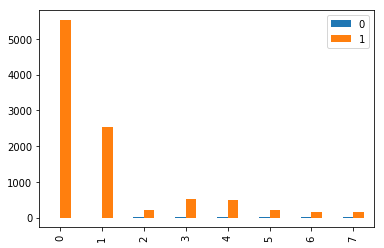

In [16]:
labels = dbScan_labels
cluster_sizes = []
for label in sorted(set(labels)):
    cluster_sizes.append([label, len(baskets_scores_df[labels == label])])
pd.DataFrame(cluster_sizes).plot(kind='bar')


Select one cluster and calculate its overall score (the average of the scores of all the items in a cluster)

In [17]:
for selected_basket_cluster in set(labels):
    print("Cluster ", selected_basket_cluster)
    selected_basket_scores = baskets_scores_df[labels == selected_basket_cluster]
    print("#Baskets: ", selected_basket_scores.shape[0])
    
    aggregated_basket_cluster_score = np.mean(selected_basket_scores, axis=0).sort_values(ascending=False)
    selected_baskets = list(compress(baskets, labels == selected_basket_cluster))
    selected_baskets = [' '.join(l) for l in selected_baskets]
    aggregated_basket_cluster_score = aggregated_basket_cluster_score[0:50]
    print(aggregated_basket_cluster_score)

Cluster  0
#Baskets:  2544
moroccan       -0.338919
spanish        -0.354953
korean         -0.367876
japanese       -0.386665
chinese        -0.409628
indian         -0.411569
vietnamese     -0.423112
italian        -0.430406
mexican        -0.466223
cajun_creole   -0.496746
greek          -0.506836
jamaican       -0.532024
russian        -0.532127
french         -0.549063
filipino       -0.549985
southern_us    -0.560140
thai           -0.562543
brazilian      -0.566559
british        -0.567578
irish          -0.649748
dtype: float64
Cluster  1
#Baskets:  212
greek           0.732743
moroccan       -0.338919
spanish        -0.354953
korean         -0.367876
japanese       -0.386665
chinese        -0.409628
indian         -0.411569
vietnamese     -0.423112
italian        -0.430406
mexican        -0.466223
cajun_creole   -0.496746
jamaican       -0.532024
russian        -0.532127
french         -0.549063
filipino       -0.549985
southern_us    -0.560140
thai           -0.562543
brazili

#### Baseline method - K-means
Now we will implement the baseline algorithm to compare with our method. K-means is used. We choose a K in the order of 
the cluster obtained by the DBSCAN algorithm.

In [18]:
baskets_as_docs = [' '.join(basket) for basket in baskets]
X_Baskets = vectorizer.fit_transform(baskets_as_docs)
model = KMeans(n_clusters=8, init='k-means++', max_iter=100, n_init=1)
model.fit(X_Baskets)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
baseline_labels = set(model.labels_)
# print("Top terms per cluster:")
# for i in baseline_labels:
#     print("Cluster %d:" % i),
#     for ind in order_centroids[i, :10]:
#         print(' %s' % terms[ind])

#### Compute Scores of Baskets created using K-Means
For the created clusters of baskets using the baseline method, we calculate its scores in terms of similarity with the 
terms that scored high TF-IDF for the cuisines 

In [19]:
baseline_baskets_scores = {}
for cluster in baseline_labels:
    basket_scores = baskets_scores_df[model.labels_ == cluster]
    cluster_scores = np.mean(basket_scores,axis=0).sort_values()
    np.argsort(cluster_scores)
    print("Cluster size:",len(basket_scores))
    print(cluster_scores)
   


Cluster size: 3761
brazilian      -0.079377
irish          -0.067930
british        -0.033764
southern_us    -0.028406
russian        -0.012241
thai            0.003194
jamaican        0.007057
filipino        0.025608
french          0.035010
greek           0.036849
japanese        0.043054
korean          0.052533
vietnamese      0.053508
cajun_creole    0.054001
italian         0.058327
chinese         0.062107
indian          0.075734
mexican         0.086880
moroccan        0.087957
spanish         0.095248
dtype: float64
Cluster size: 307
british        -0.525025
southern_us    -0.516244
brazilian      -0.511012
french         -0.491657
russian        -0.477867
thai           -0.476811
filipino       -0.470434
jamaican       -0.467678
greek          -0.461089
cajun_creole   -0.450067
mexican        -0.435458
italian        -0.394376
vietnamese     -0.373011
chinese        -0.356768
indian         -0.347302
japanese       -0.328689
spanish        -0.327614
korean         -0.32453